In [15]:
# Qiskit packages
import networkx as nx
from qiskit import BasicAer, IBMQ
from qiskit.quantum_info import Pauli
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import SPSA
import qiskit as qk
from qiskit.algorithms import QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit.opflow import Z, I
from ibm_quantum_widgets import CircuitComposer
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi
import qiskit as qk
import numpy as np
import matplotlib.pyplot as plt
from qiskit import execute

In [5]:
# Create a quantum circuit function to solve flight route optimisation problem and evaluate the results
def arp_circuit(nodes, routes, num_qubits, num_ancillas, depth, seed=None):
    """Create a quantum circuit to solve the ARP problem."""
    if seed is not None:
        np.random.seed(seed)
    qr = qk.QuantumRegister(num_qubits)
    cr = qk.ClassicalRegister(num_qubits)
    qc = qk.QuantumCircuit(qr, cr)
    # apply hadamard gates to all qubits
    for i in range(num_qubits):
        qc.h(qr[i])
    # apply barrier
    qc.barrier()
    # apply random rotations to all qubits
    for i in range(num_qubits):
        qc.rx(2 * np.pi * np.random.rand(), qr[i])
        qc.ry(2 * np.pi * np.random.rand(), qr[i])
        qc.rz(2 * np.pi * np.random.rand(), qr[i])
    # apply barrier
    qc.barrier()
    # repeat the following `depth` times
    for _ in range(depth):
        # apply CNOTs
        for i in range(num_qubits):
            for j in range(i + 1, num_qubits):
                qc.cx(qr[i], qr[j])
        # apply barrier
        qc.barrier()
        # apply random rotations to all qubits
        for i in range(num_qubits):
            qc.rx(2 * np.pi * np.random.rand(), qr[i])
            qc.ry(2 * np.pi * np.random.rand(), qr[i])
            qc.rz(2 * np.pi * np.random.rand(), qr[i])
        # apply barrier
        qc.barrier()
    # apply CNOTs
    for i in range(num_qubits):
        for j in range(i + 1, num_qubits):
            qc.cx(qr[i], qr[j])
    # apply barrier
    qc.barrier()
    # measure all qubits
    for i in range(num_qubits):
        qc.measure(qr[i], cr[i])
    return qc

# create a randomly generated flight route data set
def generate_data(num_nodes, num_routes, seed=None):
    """Generate a random flight route data set."""
    if seed is not None:
        np.random.seed(seed)
    nodes = np.random.rand(num_nodes, 2)
    routes = np.random.randint(0, num_nodes, (num_routes, 2))
    return nodes, routes

generate_data(5, 10, seed=1)

(array([[4.17022005e-01, 7.20324493e-01],
        [1.14374817e-04, 3.02332573e-01],
        [1.46755891e-01, 9.23385948e-02],
        [1.86260211e-01, 3.45560727e-01],
        [3.96767474e-01, 5.38816734e-01]]),
 array([[2, 4],
        [3, 4],
        [2, 4],
        [2, 4],
        [1, 1],
        [0, 1],
        [1, 1],
        [1, 0],
        [4, 1],
        [0, 0]]))

{'100': 271, '110': 335, '000': 234, '011': 21, '111': 16, '101': 36, '010': 83, '001': 4}


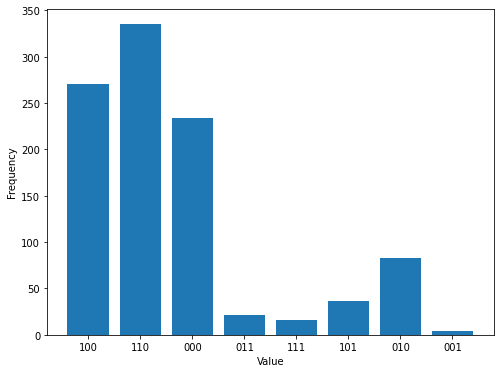

In [16]:
# Run the function and evaluate it
num_nodes = 3
num_routes = 5
nodes, routes = generate_data(num_nodes, num_routes, seed=1)
num_qubits = num_nodes * (num_nodes - 1) // 2 # 3
num_ancillas = 0
depth = 1
qc = arp_circuit(nodes, routes, num_qubits, num_ancillas, depth, seed=1)
backend = qk.BasicAer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1000)
result = job.result()
counts = result.get_counts(qc)
print(counts)



# plot a histogram
def plot_histogram(data, title=None, figsize=(8, 6)):
    """Plot a histogram."""
    plt.figure(figsize=figsize)
    plt.bar(range(len(data)), data.values(), align='center')
    plt.xticks(range(len(data)), data.keys())
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    if title is not None:
        plt.title(title)
    plt.show()
    
plot_histogram(counts)

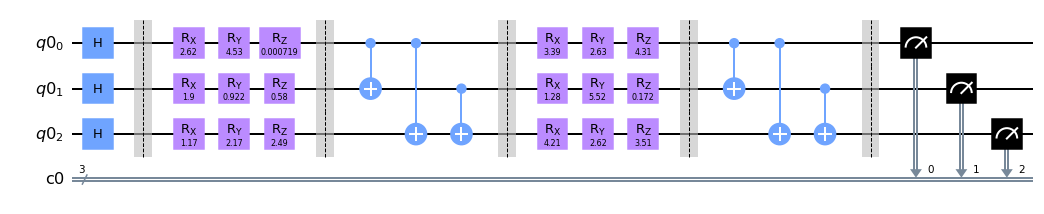

In [9]:
# Visualise the solution
qc.draw(output='mpl')